In [10]:
import torch
import torch.nn as nn

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## data generation

In [13]:
def generate_data(T, N):
    Sigma = stats.invwishart.rvs(df=2*(N+1), scale=np.eye(N))*(2*(N+1)-N-1)
    R = np.random.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T).T
    return Sigma, R

In [14]:
def generate_financial_covariance(T,N, n_factors=5, market_strength=0.7, sector_strength=0.25, noise_strength=0.1):
    # Market factor (common to all assets) — how each asset react to the market
    market_loadings = np.random.uniform(0.5, 1.0, size=(N, 1))
    Sigma_market = market_strength * (market_loadings @ market_loadings.T)
    # market strength :control how dominant the market effect is

    # sector factors (clustered correlations)
    n_sectors = n_factors - 1 # one market + n_sectors sectors
    sector_size = N // n_sectors
    Sigma_sectors = np.zeros((N, N))
    for s in range(n_sectors):
        idx = slice(s * sector_size, (s + 1) * sector_size)
        A = np.random.randn(sector_size, sector_size) # random factor matrix (like for market but localy here)
        Sigma_sectors[idx, idx] = sector_strength * (A @ A.T) / sector_size # assets in the same sector have additional correlations beyond the market

    # Idiosyncratic noise (diagonal)
    diag_noise = noise_strength * np.random.uniform(0.5, 1.5, N)
    Sigma_diag = np.diag(diag_noise) # unique risk per asset, unsure that the matrix is full-rank also

    # Combine all components
    Sigma = Sigma_market + Sigma_sectors + Sigma_diag

    # Normalize trace - > tend to a trace = N, nice for later when we compare cleaned vs noisy vs true cov matrix
    Sigma *= N / np.trace(Sigma)

    R = np.random.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T).T # log return are normally distributed

    return Sigma,R


In [15]:
def make_monotone_pattern(R):
    n, T = R.shape

    t = np.concatenate([np.random.default_rng().integers(low=T//2.5, high=T+1, size=n-1), [T]])
    t_vec = T - np.sort(t)[::-1]

    cols = np.arange(T)[None, :]

    mask = cols >= t_vec[:, None]

    R_mono = R.copy().astype(float)
    R_mono[~mask] = -5.0

    return R_mono, t_vec, mask


In [16]:
def fit_monotone_regressions(R, t_vec):
    n, T = R.shape
    phi_list = []
    for k in range(n):
        t_k = t_vec[k]
        y = R[k,t_k:]
        if k==0:
            beta0 = np.nanmean(R[0, :])
            beta = np.array([])
            resid = y - beta0
            sigma2 = float(resid.T @ resid) / len(resid)
            phi_list.append((beta0, beta, sigma2))
        else:
            X = R[:k,t_k:].T
            reg = LinearRegression(fit_intercept=True)
            reg.fit(X, y)

            beta0 = reg.intercept_
            beta = reg.coef_
            resid = y -reg.predict(X)

            sigma2 = (resid.T @ resid) / len(resid) 
            phi_list.append((beta0, beta, sigma2))
    return phi_list

In [17]:
import numpy as np

def reconstruct_mu_sigma_from_phi(phi_list):

    p = len(phi_list)
    mu = np.zeros(p, dtype=float)
    Sigma = np.zeros((p, p), dtype=float)

    beta0_1, beta_1, sigma2_1 = phi_list[0]
    mu[0] = beta0_1
    Sigma[0, 0] = sigma2_1 

    for k in range(1, p):
        beta0_k, beta_k, sigma2_k = phi_list[k]

        mu[k] = beta0_k + beta_k @ mu[:k]

        S11 = Sigma[:k, :k]

        cross = beta_k @ S11
        Sigma[k, :k] = cross
        Sigma[:k, k] = cross.T

        Sigma[k, k] = sigma2_k + cross @ beta_k.T

    return mu, Sigma


## Global function for data generation

In [18]:
def generate_batch(N, T, batch_size, function):
    Sigma_hat_batch = []
    sigma_batch = []
    for _ in range(batch_size):
        Sigma, R = function(T, N)
        R_hat, t_vec, _ = make_monotone_pattern(R)
        
        _, Sigma_hat = reconstruct_mu_sigma_from_phi(fit_monotone_regressions(R_hat, t_vec))
        Sigma_hat_batch.append(Sigma_hat)
        sigma_batch.append(Sigma)

    return np.array(Sigma_hat_batch), np.array(sigma_batch)

## data formating for NN

In [58]:
def eigen_decomp(Sigma):
    vals, vecs = np.linalg.eig(Sigma)
    # sort desending
    # for Sigma in Sigmas
    idx = np.argsort(vals)[::-1]
    return vals[idx], vecs[:, idx]

$$\hat{\Sigma} = \hat{Q} \hat{\Lambda} \hat{Q}^T$$

$$\tilde{\Sigma}_{NN} = \hat{Q} \tilde{\Lambda}_{NN} \hat{Q}^T$$

## generator of the data as suggested by Prof B

In [96]:
def data_generator(batch_size, N_min=20, N_max=100, T_min=50, T_max=300):
    while True:
        N = np.random.randint(N_min, N_max+1)
        T = np.random.randint(T_min, T_max+1)

        lam_emp_list = []
        Q_list = []
        Sigma_true_list = []

        for _ in range(batch_size):

            # sample true covariance
            df = np.random.uniform(2*(N+1), 10*N) 
            # as suggested by prof B so that the population will not be the same and 
            # so we don't have the neural network that will learn directly the target without looking at the input. 
            Sigma_true = stats.invwishart.rvs(df=df, scale=np.eye(N))*(2*(N+1)-N-1)

            # Simulate T samples
            R = np.random.multivariate_normal(np.zeros(N), Sigma_true, size=T).T

            # Empirical covariance
            R_hat, t_vec, _ = make_monotone_pattern(R)
            _, Sigma_hat = reconstruct_mu_sigma_from_phi(fit_monotone_regressions(R_hat, t_vec))

            #sort eigenvalues
            lam_emp, Q_emp = eigen_decomp(Sigma_hat)
            # Store
            lam_emp_list.append(lam_emp.squeeze())
            Q_list.append(Q_emp)
            Sigma_true_list.append(Sigma_true)


        lam_emp = torch.tensor(np.array(lam_emp_list), dtype=torch.float32).unsqueeze(-1)
        Q_emp = torch.tensor(np.array(Q_list), dtype=torch.float32)
        Sigma_true = torch.tensor(np.array(Sigma_true_list), dtype=torch.float32)

        # Yield batch
        yield lam_emp, Q_emp, Sigma_true, T

## NN

In [97]:
class BiGRUSpectralDenoiser(nn.Module):
    def __init__(self, hidden_size): 
        # N : the number of eigenvalues per sample; 
        # hidden_size : the dimension of the GRU’s hidden state
        super().__init__()

        self.gru = nn.GRU(
            input_size=1, #The number of input features per sequence data, 1 here
            hidden_size=hidden_size, #Tumber of features in the hidden state, one still one eigenvalue
            num_layers=1, # amount of GRU we put one after-another
            bias=True, # We always want bias
            batch_first=True, #input and output tensors are provided as (batch, seq, feature)
            bidirectional=True #
            )
        self.fc = nn.Linear(2 * hidden_size, 1) # we apply a Dense(2H to 1) at each time step
        self.activation = nn.Softplus() # keeps positive eigenvalues

    def forward(self, x):
        h, _ = self.gru(x) # (B, N, 2H)
        out = self.fc(h)
        out = out.squeeze(-1)
        out = self.activation(out)
        return out

In [105]:
model = BiGRUSpectralDenoiser(hidden_size=64) # hidden_size to be tunned

In [209]:
def loss_function(lam_pred, Q, Sigma_true, T):
    N = Sigma_true.shape[1]

    Lambda_pred = torch.diag_embed(lam_pred)
    print(Lambda_pred.shape, Q.shape, Sigma_true.shape)
    Sigma_pred = Q @ Lambda_pred @ Q.transpose(1, 2)

    frob_error = ((Sigma_pred - Sigma_true)**2).sum(dim=(1,2)) 
    loss_cov = (T / N**2) * frob_error.mean()

    return loss_cov

In [107]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6) # lr and weight_decay to be tuned

### Training loop

On pourra rajouter dans la loss un terme pour comparer les valeurs propres/les matrices totals par exemples des matrices.

On pourrait calculer la loss par epochs d'une tailles plus petites ou même aléatoire

In [108]:
losses = []

In [144]:
N_min=50
N_max=150
T_min=80
T_max=200

In [145]:
# batch are full for now
batch_size = 32
epochs = 350
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    lam_emp, Q_emp, Sigma_true, T = next(data_generator(batch_size, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max))
    lam_pred = model(lam_emp)  # forward pass through the NN (GRU+fc)

    # compute losses
    loss = loss_function(lam_pred, Q_emp, Sigma_true, T)

    # backprop
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # very noisy optimization we could increase lr when we could lower that certain value
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} — loss: {loss.item():.6f}")


Epoch 20/450 — loss: 0.120565
Epoch 40/450 — loss: 0.071266
Epoch 60/450 — loss: 0.133395
Epoch 80/450 — loss: 0.076894
Epoch 100/450 — loss: 0.104865
Epoch 120/450 — loss: 0.138237
Epoch 140/450 — loss: 0.058877
Epoch 160/450 — loss: 0.080861
Epoch 180/450 — loss: 0.229259
Epoch 200/450 — loss: 0.062769
Epoch 220/450 — loss: 0.046550
Epoch 240/450 — loss: 0.068159
Epoch 260/450 — loss: 0.063208
Epoch 280/450 — loss: 0.105234
Epoch 300/450 — loss: 0.124106
Epoch 320/450 — loss: 0.208394
Epoch 340/450 — loss: 0.143480
Epoch 360/450 — loss: 0.040548
Epoch 380/450 — loss: 0.082846
Epoch 400/450 — loss: 0.076378
Epoch 420/450 — loss: 0.063016
Epoch 440/450 — loss: 0.071984


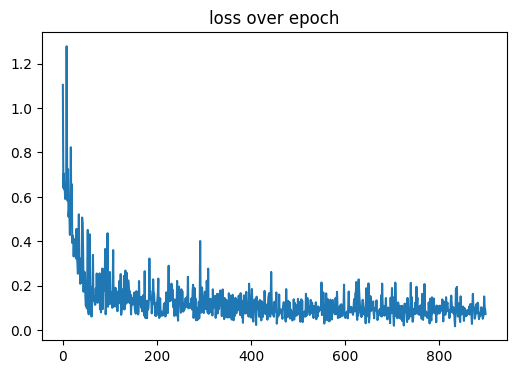

In [146]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("loss over epoch")
plt.show()

we have to stop after the slow down of deacrese. otherwise we might face overfitting

### out of sample comparaison 1

In [245]:
batch_size_oos_1 = 25
N_list_test_1 = [40, 60, 80, 100, 120, 140, 160]
T_list_test_1 = [60, 80, 100, 120, 150, 180, 200, 220, 240, 260]

In [246]:
losses_t = []
losses_n = []

In [247]:
T = 100
N = 80

In [248]:
for n in N_list_test_1:
    for t in T_list_test_1:
        lam_emp_oos_i, Q_emp_oos_i, Sigma_true_oos_i, T_t = next(data_generator(batch_size_oos_1, N_min=n, N_max=n, T_min=t, T_max=t))
        lam_pred_test_i = model(lam_emp_oos_i)
        losses_t.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())


torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 40, 40]) torch.Size([25, 40, 40]) torch.Size([25, 40, 40])
torch.Size([25, 60, 60]) torch.Size([25, 60, 60]) torch.Size([25, 60, 60])
torch.Size([25, 60, 60]) torch.Size([25, 60, 60]) torch.Size([25, 60, 60])
torch.Size([25, 60, 60]) torch.Size([25, 60, 60]) torch.Size([25, 60, 60])
torch.Size([25, 60, 60]) 

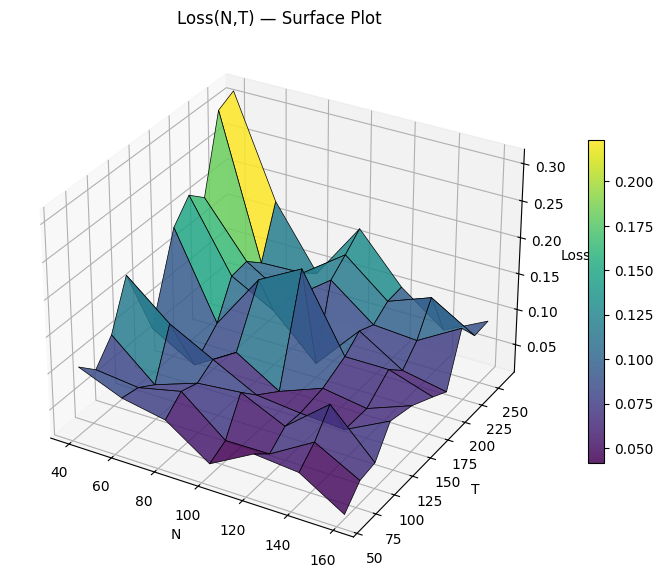

In [265]:
# meshing
loss_grid = np.array(losses_t).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss(N,T) — Surface Plot")

fig.colorbar(surf, shrink=0.6)
plt.show()


### out of sample comparaison 2

In [218]:
batch_size_oos = 1000

In [219]:
lam_emp_oos, Q_emp_oos, Sigma_true_oos, T = next(data_generator(batch_size_oos, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max))


In [220]:
lam_emp_oos.shape

torch.Size([1000, 107, 1])

In [221]:
lam_pred_test = model(lam_emp_oos)

Comparaison eigenvalues $\lambda$

In [222]:
# mse
mse = nn.MSELoss()

In [223]:
lam_true_oos = torch.tensor(np.array([eigen_decomp(Sigma.numpy())[0] for Sigma in Sigma_true_oos]), dtype=torch.float32)


mse_pred_test_lam  = mse(lam_pred_test, lam_true_oos)
mse_noisy_test_lam = mse(lam_true_oos, lam_emp_oos.squeeze(-1))

print(f"MSE cleaned: {mse_pred_test_lam:.6f}")
print(f"MSE noisy  : {mse_noisy_test_lam:.6f}")


MSE cleaned: 0.025522
MSE noisy  : 1420283.625000


Comparaison Trace

In [169]:
trace_true_test = lam_true_oos.sum(dim=1).mean()
trace_pred_test = lam_pred_test.sum(dim=1).mean()
trace_noisy_test = lam_emp_oos.sum(dim=1).mean()

mse_tr_test_pred = mse(trace_true_test,trace_pred_test)
mse_tr_test_in = mse(trace_true_test,trace_noisy_test)

print(f"Real Trace : {trace_true_test:.4f}, predicted : {trace_pred_test:.4f}, noisy : {trace_noisy_test:.4f}")
print(f"MSE tr noisy  : {mse_tr_test_pred:.6f}")
print(f"MSE tr cleaned: {mse_tr_test_in:.6f}")

Real Trace : 32.8104, predicted : 25.0397, noisy : 2303.7419
MSE tr noisy  : 60.383667
MSE tr cleaned: 5157130.500000


*10^6 fois mieux

Comparaison matrix $\Sigma$

In [170]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam.squeeze(-1))
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [ ]:
Sigma_true_test = Sigma_true_oos
Sigma_noisy_test = reconstruct_cov(Q_emp_oos, lam_emp_oos)
Sigma_pred_test   = reconstruct_cov(Q_emp_oos, lam_pred_test)

fro_noisy_test_mat = mse(Sigma_noisy_test, Sigma_true_test)
fro_pred_test_mat   = mse(Sigma_pred_test, Sigma_true_test)

print(f"mse error (noisy):  {fro_noisy_test_mat:.6f}")
print(f"mse error (GRU)  :  {fro_pred_test_mat:.6f}")

mse error (noisy):  93524.460938
mse error (GRU)  :  0.000545


supérieur à *10^6 fois mieux

Graphique : 

In [174]:
pairs = ['Matrix', 'Trace', 'EigenValues']
mse_noisy   = [fro_noisy_test_mat.item(), mse_tr_test_in.item(), mse_noisy_test_lam.item()]
mse_cleaned = [fro_pred_test_mat.item(), mse_tr_test_pred.item(), mse_pred_test_lam.item()]

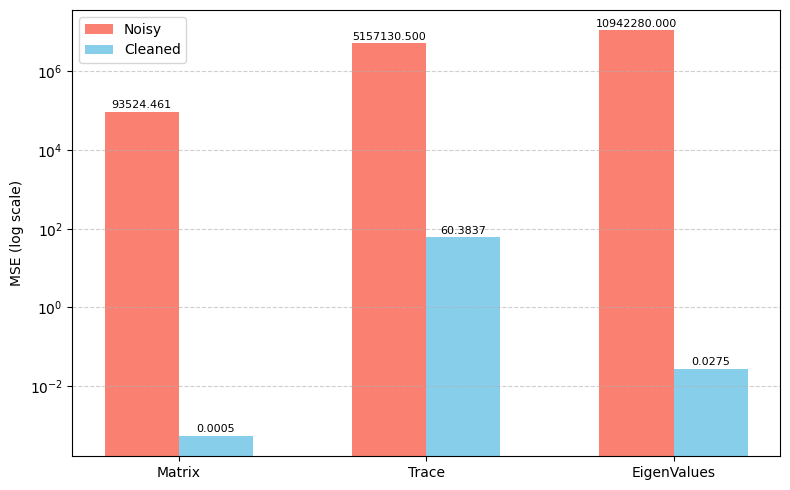

In [175]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - width/2, mse_noisy, width, label='Noisy', color='salmon')
plt.bar(x + width/2, mse_cleaned, width, label='Cleaned', color='skyblue')

plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c) in enumerate(zip(mse_noisy, mse_cleaned)):
    plt.text(x[i] - width/2, n*1.1, f"{n:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width/2, c*1.1, f"{c:.4f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()
